In [29]:
import numpy as np
import pandas as pd
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.models.detection import transform
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import RandomChoice

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
from PIL import Image

In [30]:
batch_size = 32
epochs_number = 200
patience = 5

In [31]:
#Create dataset
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [32]:
#Model
class CardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3(self.conv3(x))))
        x = self.pool(F.gelu(self.bn4(self.conv4(x))))  
        
        x = x.view(x.size(0), -1)
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout2(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout3(x)
        
        output = self.fc4(x)
        return output

In [33]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomRotation(degrees=30)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)), #Resize to 128x128
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_folder = r'C:\Users\piotr\Desktop\data\train'
valid_folder = r'C:\Users\piotr\Desktop\data\valid'
test_folder = r'C:\Users\piotr\Desktop\data\test'

train_dataset = PlayingCardDataset(train_folder, transform=transform_train)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# Early stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = float('inf')
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = "Stopping training"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:

num_epochs = epochs_number
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model = CardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-04)

es = EarlyStopping(patience=patience)

epoch = 0
done = False
while epoch < num_epochs and not done:
    epoch += 1
    # Training phase
    model.train()
    running_loss, running_corrects = 0.0, 0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)  # Pobieranie prognoz
        running_corrects += (preds == labels).sum().item()
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = running_corrects / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)  # Pobieranie prognoz
            running_corrects += (preds == labels).sum().item()
    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = running_corrects / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(
        f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}, Train acc: {train_accuracy:.4f}, Val acc: {val_accuracy:.4f}")

    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/200 - Train loss: 3.5441, Validation loss: 2.3486, Train acc: 0.0850, Val acc: 0.2340
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/200 - Train loss: 2.6655, Validation loss: 1.8748, Train acc: 0.2137, Val acc: 0.3509
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/200 - Train loss: 2.3596, Validation loss: 1.6586, Train acc: 0.2677, Val acc: 0.3887
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/200 - Train loss: 2.1985, Validation loss: 1.6144, Train acc: 0.3021, Val acc: 0.3962
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/200 - Train loss: 2.0507, Validation loss: 1.3656, Train acc: 0.3444, Val acc: 0.5019
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/200 - Train loss: 1.9181, Validation loss: 1.1939, Train acc: 0.4033, Val acc: 0.5736
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/200 - Train loss: 1.7668, Validation loss: 1.0342, Train acc: 0.4537, Val acc: 0.6528
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/200 - Train loss: 1.6260, Validation loss: 0.8188, Train acc: 0.5087, Val acc: 0.7358
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/200 - Train loss: 1.5226, Validation loss: 0.7462, Train acc: 0.5388, Val acc: 0.7208
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/200 - Train loss: 1.4363, Validation loss: 0.6537, Train acc: 0.5628, Val acc: 0.7811
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11/200 - Train loss: 1.3544, Validation loss: 0.6058, Train acc: 0.5927, Val acc: 0.7887
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12/200 - Train loss: 1.2516, Validation loss: 0.5768, Train acc: 0.6203, Val acc: 0.7925
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13/200 - Train loss: 1.2256, Validation loss: 0.5241, Train acc: 0.6342, Val acc: 0.8000
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14/200 - Train loss: 1.1508, Validation loss: 0.5948, Train acc: 0.6533, Val acc: 0.8189
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15/200 - Train loss: 1.1259, Validation loss: 0.4951, Train acc: 0.6588, Val acc: 0.8453
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16/200 - Train loss: 1.0772, Validation loss: 0.5436, Train acc: 0.6720, Val acc: 0.8075
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17/200 - Train loss: 1.0335, Validation loss: 0.4397, Train acc: 0.6861, Val acc: 0.8642
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18/200 - Train loss: 0.9878, Validation loss: 0.4576, Train acc: 0.7000, Val acc: 0.8566
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19/200 - Train loss: 0.9147, Validation loss: 0.4074, Train acc: 0.7276, Val acc: 0.8830
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20/200 - Train loss: 0.8954, Validation loss: 0.3825, Train acc: 0.7365, Val acc: 0.8981
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21/200 - Train loss: 0.8758, Validation loss: 0.3950, Train acc: 0.7390, Val acc: 0.8906
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22/200 - Train loss: 0.8306, Validation loss: 0.3872, Train acc: 0.7504, Val acc: 0.8943
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23/200 - Train loss: 0.7785, Validation loss: 0.3612, Train acc: 0.7718, Val acc: 0.9132
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24/200 - Train loss: 0.7532, Validation loss: 0.2982, Train acc: 0.7787, Val acc: 0.9208
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25/200 - Train loss: 0.7197, Validation loss: 0.3164, Train acc: 0.7951, Val acc: 0.9132
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26/200 - Train loss: 0.6682, Validation loss: 0.3279, Train acc: 0.8040, Val acc: 0.9283
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27/200 - Train loss: 0.6870, Validation loss: 0.2761, Train acc: 0.7992, Val acc: 0.9321
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28/200 - Train loss: 0.6540, Validation loss: 0.3273, Train acc: 0.8147, Val acc: 0.9170
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29/200 - Train loss: 0.6094, Validation loss: 0.3524, Train acc: 0.8191, Val acc: 0.9057
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30/200 - Train loss: 0.6104, Validation loss: 0.3631, Train acc: 0.8223, Val acc: 0.9208
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31/200 - Train loss: 0.5746, Validation loss: 0.2940, Train acc: 0.8362, Val acc: 0.9283
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32/200 - Train loss: 0.5572, Validation loss: 0.2522, Train acc: 0.8350, Val acc: 0.9321
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33/200 - Train loss: 0.5579, Validation loss: 0.2057, Train acc: 0.8417, Val acc: 0.9472
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34/200 - Train loss: 0.5078, Validation loss: 0.2993, Train acc: 0.8555, Val acc: 0.9283
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35/200 - Train loss: 0.5268, Validation loss: 0.2953, Train acc: 0.8547, Val acc: 0.9094
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36/200 - Train loss: 0.4926, Validation loss: 0.2086, Train acc: 0.8600, Val acc: 0.9547
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37/200 - Train loss: 0.4827, Validation loss: 0.2146, Train acc: 0.8654, Val acc: 0.9509
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38/200 - Train loss: 0.4827, Validation loss: 0.1917, Train acc: 0.8670, Val acc: 0.9472
Early Stopping: 0/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39/200 - Train loss: 0.4548, Validation loss: 0.2853, Train acc: 0.8705, Val acc: 0.9434
Early Stopping: 1/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40/200 - Train loss: 0.4412, Validation loss: 0.2983, Train acc: 0.8708, Val acc: 0.9472
Early Stopping: 2/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41/200 - Train loss: 0.4457, Validation loss: 0.2361, Train acc: 0.8742, Val acc: 0.9434
Early Stopping: 3/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42/200 - Train loss: 0.4289, Validation loss: 0.2807, Train acc: 0.8780, Val acc: 0.9396
Early Stopping: 4/5


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43/200 - Train loss: 0.4285, Validation loss: 0.2145, Train acc: 0.8781, Val acc: 0.9547
Early Stopping: Stopping training


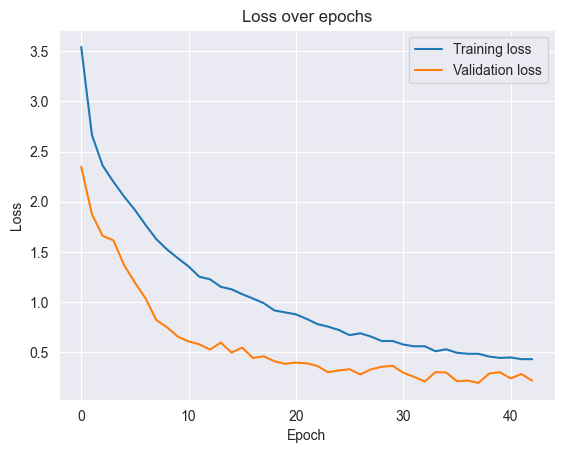

In [37]:
#Visualize Losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

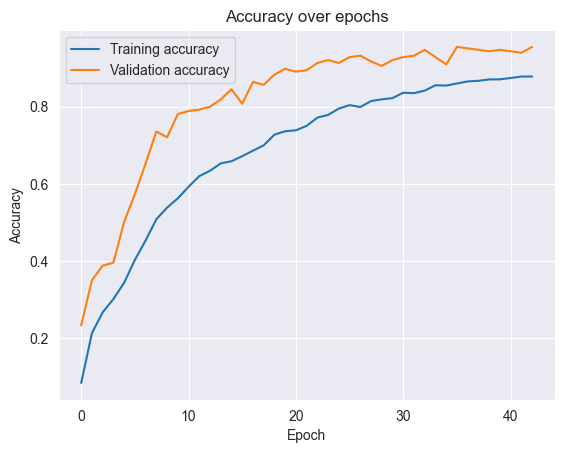

In [38]:
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [39]:
# Calculate the Accuracy of the Model using test data

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 94.72%


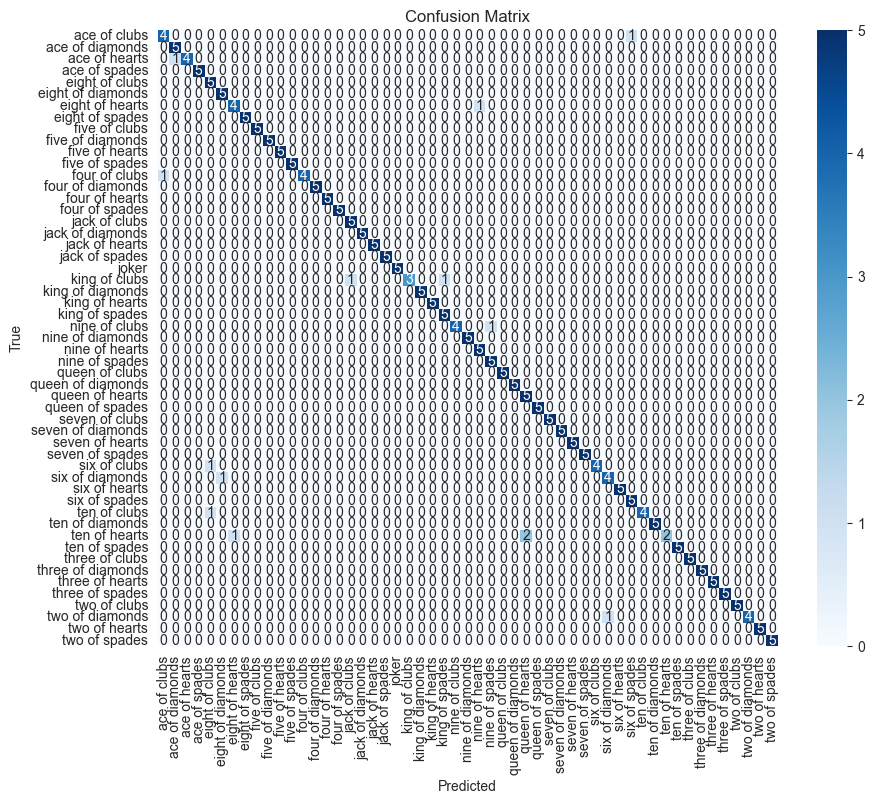

In [40]:
# Calculate predictions on test data
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [41]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

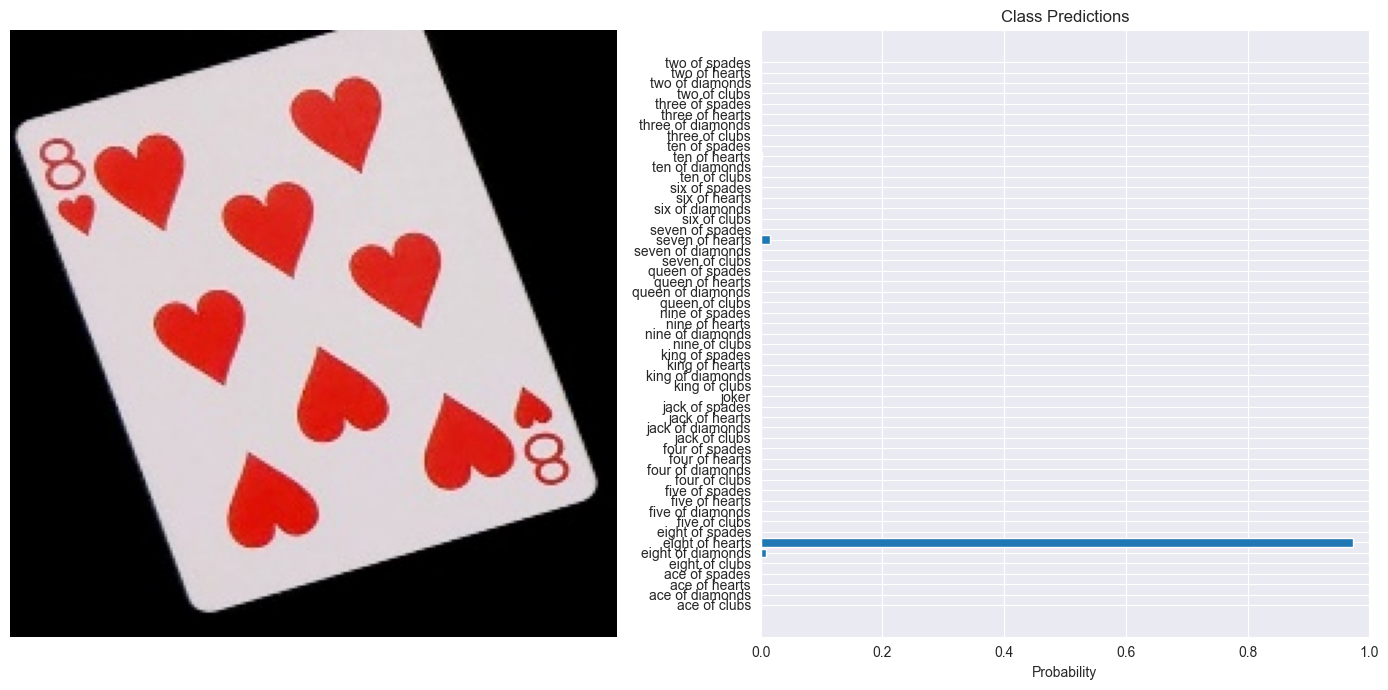

In [43]:
dataset = PlayingCardDataset(r'C:\Users\piotr\Desktop\data\train')
test_image = r'C:\Users\piotr\Desktop\data\test\ace of spades\2.jpg'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)


class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)